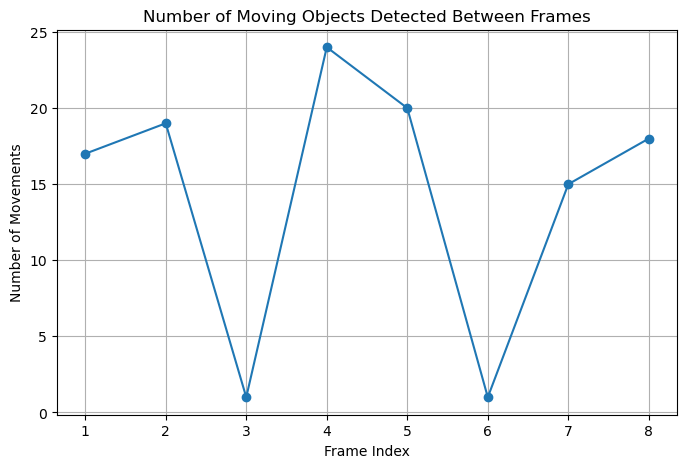

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the image (9 frames in 1 grid)
img = cv2.imread('Train1.png')

# Add these two lines to check
if img is None:
    raise ValueError("Image not found. Please check the file path!")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Split the image into 9 frames
frames = []
h, w, _ = img.shape
frame_h = h // 3
frame_w = w // 3

for i in range(3):
    for j in range(3):
        frame = img[i*frame_h:(i+1)*frame_h, j*frame_w:(j+1)*frame_w]
        frames.append(frame)

# Now simulate motion detection between consecutive frames
moving_objects = []

for idx in range(len(frames)-1):
    frame1 = cv2.cvtColor(frames[idx], cv2.COLOR_RGB2GRAY)
    frame2 = cv2.cvtColor(frames[idx+1], cv2.COLOR_RGB2GRAY)

    # Frame difference
    diff = cv2.absdiff(frame1, frame2)
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Find contours (moving parts)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small movements
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 50:  # filter noise
            count += 1

    moving_objects.append(count)

# Plot the result
plt.figure(figsize=(8,5))
plt.plot(range(1, len(frames)), moving_objects, marker='o')
plt.title('Number of Moving Objects Detected Between Frames')
plt.xlabel('Frame Index')
plt.ylabel('Number of Movements')
plt.grid()
plt.show()


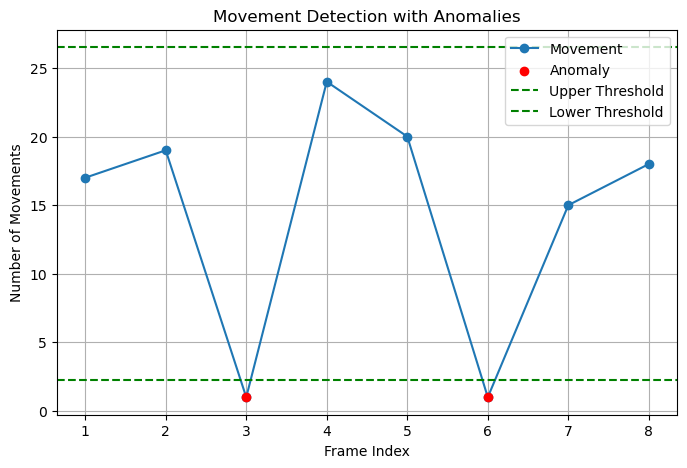

In [12]:
import numpy as np

# Calculate basic stats
movement_array = np.array(moving_objects)
mean_movement = np.mean(movement_array)
std_movement = np.std(movement_array)

# Define anomaly threshold
upper_threshold = mean_movement + 1.5 * std_movement
lower_threshold = mean_movement - 1.5 * std_movement

# Find anomalies
anomalies = []
for idx, value in enumerate(movement_array):
    if value > upper_threshold or value < lower_threshold:
        anomalies.append(idx + 1)  # +1 because frame indices start from 1 in the plot

# Plot again with anomalies marked
plt.figure(figsize=(8,5))
plt.plot(range(1, len(frames)), moving_objects, marker='o', label='Movement')
plt.scatter(anomalies, [moving_objects[i-1] for i in anomalies], color='red', label='Anomaly', zorder=5)
plt.title('Movement Detection with Anomalies')
plt.xlabel('Frame Index')
plt.ylabel('Number of Movements')
plt.axhline(upper_threshold, color='green', linestyle='--', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
plt.legend()
plt.grid()
plt.show()


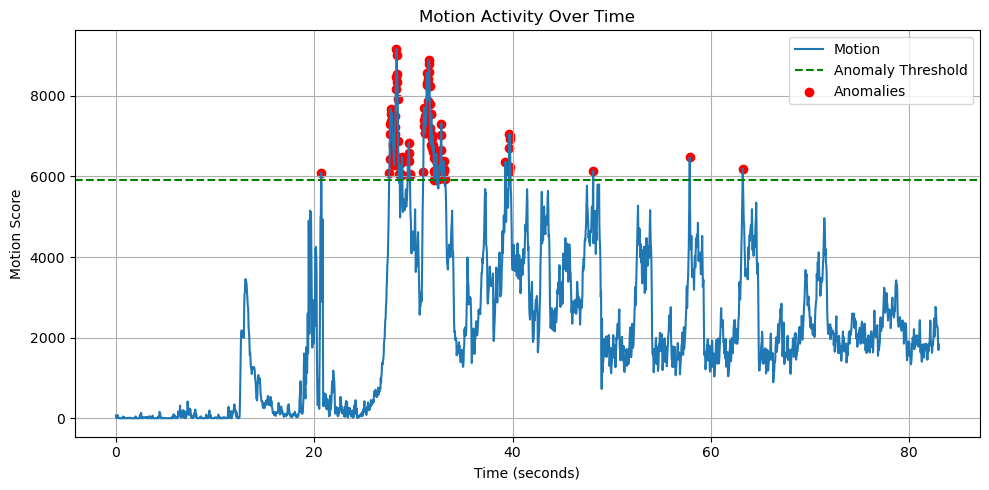

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load video
video_path = 'Train Station Video 1.mp4'
cap = cv2.VideoCapture(video_path)

motion_values = []
prev_frame = None
frame_index = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Resize for speed
    frame = cv2.resize(frame, (320, 240))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    if prev_frame is None:
        prev_frame = gray
        continue

    # Frame differencing
    diff = cv2.absdiff(prev_frame, gray)
    _, thresh = cv2.threshold(diff, 35, 255, cv2.THRESH_BINARY)

    # Count non-zero pixels (motion magnitude)
    motion_score = np.sum(thresh) / 255
    motion_values.append(motion_score)

    prev_frame = gray
    frame_index += 1

cap.release()

# Normalize to motion per second (assuming ~30 FPS)
fps = 30
seconds = len(motion_values) // fps
time_axis = np.linspace(0, seconds, len(motion_values))

# Simple anomaly detection: find spikes
motion_array = np.array(motion_values)
mean = np.mean(motion_array)
std = np.std(motion_array)
upper = mean + 2 * std

anomaly_indices = [i for i, val in enumerate(motion_array) if val > upper]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_axis, motion_array, label='Motion')
plt.axhline(upper, color='green', linestyle='--', label='Anomaly Threshold')
plt.scatter([time_axis[i] for i in anomaly_indices],
            [motion_array[i] for i in anomaly_indices],
            color='red', label='Anomalies')
plt.title('Motion Activity Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Motion Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


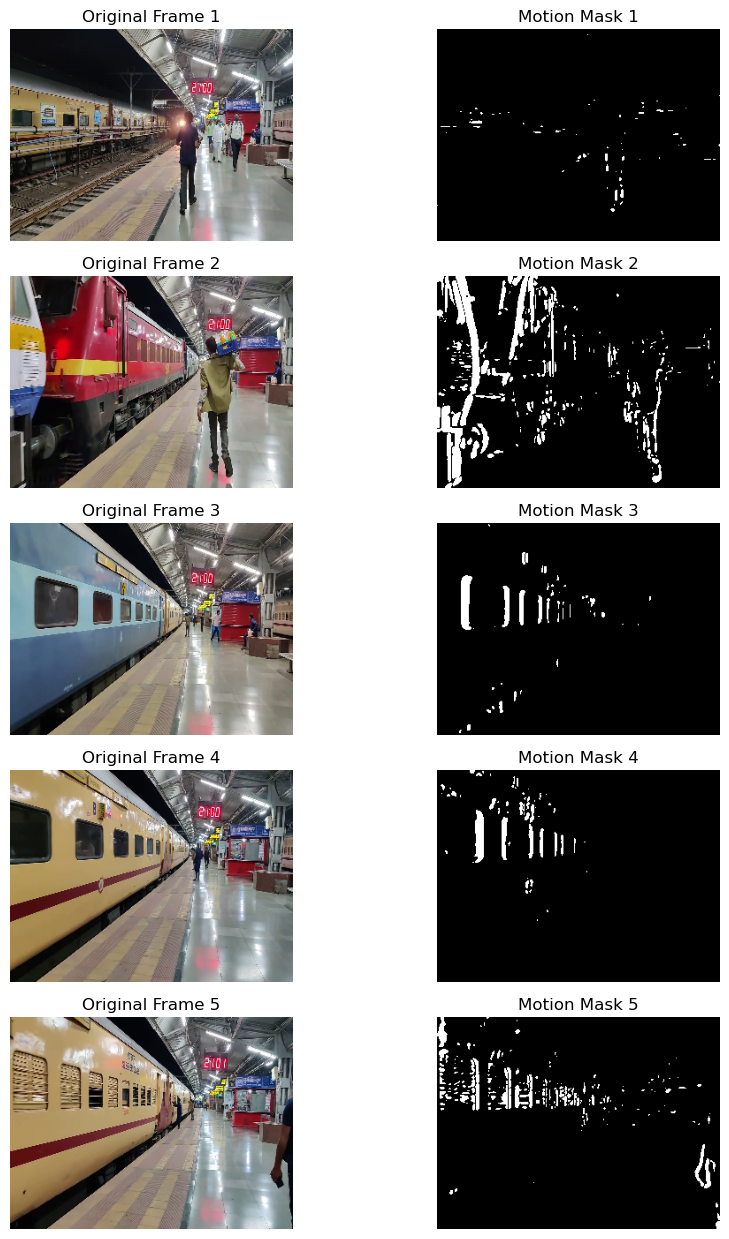

In [2]:
import matplotlib.pyplot as plt

# Reopen video to extract example frames and motion masks
cap = cv2.VideoCapture(video_path)

example_frames = []
example_masks = []
prev_frame = None
count = 0
max_examples = 5  # How many frame pairs to show
frame_interval = len(motion_values) // max_examples

while cap.isOpened() and len(example_frames) < max_examples:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize and convert to grayscale
    frame = cv2.resize(frame, (320, 240))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    if prev_frame is not None:
        # Frame differencing and thresholding
        diff = cv2.absdiff(prev_frame, gray)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

        if count % frame_interval == 0:
            # Save original and mask
            example_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # for display
            example_masks.append(thresh)

    prev_frame = gray
    count += 1

cap.release()

# Plot results
fig, axes = plt.subplots(nrows=max_examples, ncols=2, figsize=(10, max_examples * 2.5))
for i in range(max_examples):
    axes[i, 0].imshow(example_frames[i])
    axes[i, 0].set_title(f"Original Frame {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(example_masks[i], cmap='gray')
    axes[i, 1].set_title(f"Motion Mask {i+1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [4]:
import matplotlib.pyplot as plt

# Plot motion score over time
plt.figure(figsize=(12, 6))
plt.plot(motion_df["Time (s)"], motion_df["Motion Score"], label="Motion Score", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Motion Score")
plt.title("Motion Score Over Time with Speed-Based Anomalies")

# Highlight sudden increases
increase_points = motion_df[motion_df["Anomaly Type"] == "Sudden Increase"]
plt.scatter(increase_points["Time (s)"], increase_points["Motion Score"], color='red', label="Sudden Increase")

# Highlight sudden decreases
decrease_points = motion_df[motion_df["Anomaly Type"] == "Sudden Decrease"]
plt.scatter(decrease_points["Time (s)"], decrease_points["Motion Score"], color='orange', label="Sudden Decrease")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'motion_df' is not defined

<Figure size 1200x600 with 0 Axes>

In [1]:
import cv2

cap = cv2.VideoCapture('Train_Run_6.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print(f"Resolution: {width}x{height}, FPS: {fps}")
cap.release()

Resolution: 720x1280, FPS: 25.0
